In [96]:
import math

import torch
import torch.nn.functional as F

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from ale_py import ALEInterface
from ale_py.roms import LostLuggage

from tqdm import tqdm

In [97]:
ale = ALEInterface()
ale.loadROM(LostLuggage)

In [98]:
env = gym.make('ALE/LostLuggage-v5')

In [99]:
from collections import defaultdict

class QLearningAgent:
    def __init__(self, n_actions,
                 learning_rate = 1e-3,
                 discount_factor = 1e-2,
                 epsilon = 0.05):
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.Q = defaultdict(lambda : torch.empty(n_actions))
    
    def choose_action(self, state):
        logits = self.Q[state] / 0.1
        action_probs = F.softmax(logits, dim=0)
        action = torch.multinomial(action_probs, 1).item()
        return action
    
    def update_Q(self, state, action, reward):
        max_Q = torch.argmax(self.Q[state])
        current_Q = self.Q[state][action]
        td_target = reward + self.discount_factor * max_Q
        td_error = td_target - current_Q
        self.Q[state][action] += self.learning_rate * td_error

    def train(self, env, n_episodes):
        episode_rewards = []

        for _ in tqdm(range(n_episodes)):
            env.reset()
            done = False
            total_reward = 0
            state = str()

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward
                self.update_Q(state, action, reward)
                state = str(next_state)
            
            episode_rewards.append(total_reward)
        
        return episode_rewards

In [104]:
n_episodes = 1000

agent = QLearningAgent(n_actions=env.action_space.n)

In [105]:
episode_rewards = agent.train(env=env, n_episodes=n_episodes)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [13:49<00:00,  1.21it/s]


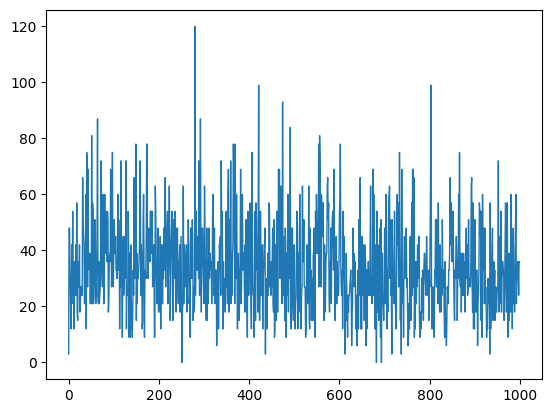

In [106]:
plt.plot(range(n_episodes), episode_rewards, linewidth=1)

In [108]:
mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)

In [109]:
print(f'Математическое ожидание: {mean_reward}')
print(f'Стандартное отклонение: {std_reward}')

Математическое ожидание: 34.254
Стандартное отклонение: 16.525963935577252


In [110]:
delta = 0.1

In [111]:
lower_bound = mean_reward - 1.645 * (std_reward / math.sqrt(300)) + delta

In [112]:
upper_bound = mean_reward + 1.645 * (std_reward / math.sqrt(300)) - delta

In [113]:
print(f'({lower_bound}, {upper_bound})')

(32.78446112993752, 35.72353887006248)


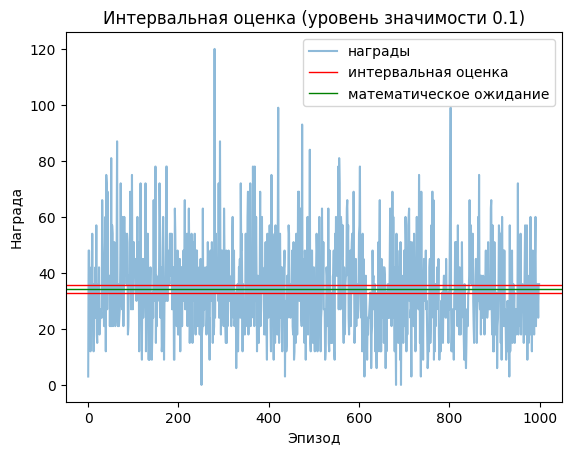

In [114]:
plt.plot(range(n_episodes), episode_rewards, alpha = 0.5)
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Интервальная оценка (уровень значимости 0.1)')
plt.axhline(upper_bound, linewidth=1, color='red')
plt.axhline(mean_reward, linewidth=1, color='green')
plt.axhline(lower_bound, linewidth=1, color='red')
plt.legend(['награды', 'интервальная оценка', 'математическое ожидание'])
plt.show()

In [115]:
delta = 0.1

In [116]:
lower_bound = mean_reward - 1.96 * (std_reward / math.sqrt(300))

In [117]:
upper_bound = mean_reward + 1.96 * (std_reward / math.sqrt(300))

In [118]:
print(f'({lower_bound}, {upper_bound})')

(32.383911133542576, 36.12408886645742)


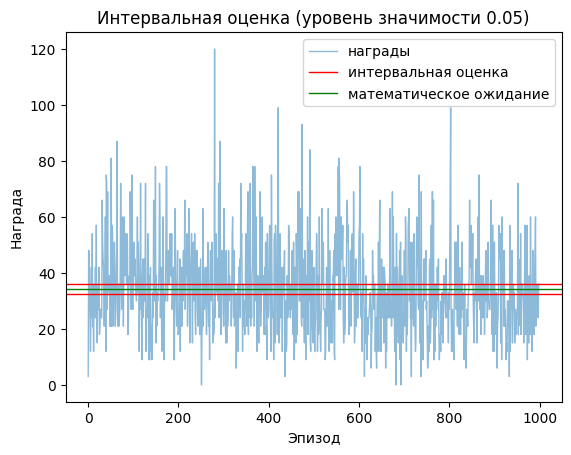

In [120]:
plt.plot(range(n_episodes), episode_rewards, alpha = 0.5, linewidth=1)
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Интервальная оценка (уровень значимости 0.05)')
plt.axhline(upper_bound, linewidth=1, color='red')
plt.axhline(mean_reward, linewidth=1, color='green')
plt.axhline(lower_bound, linewidth=1, color='red')
plt.legend(['награды', 'интервальная оценка', 'математическое ожидание'])
plt.show()